## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from torch.utils.data import DataLoader, Dataset, Subset

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

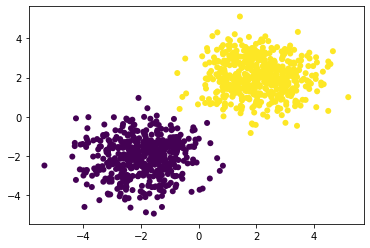

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')
plt.show()

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

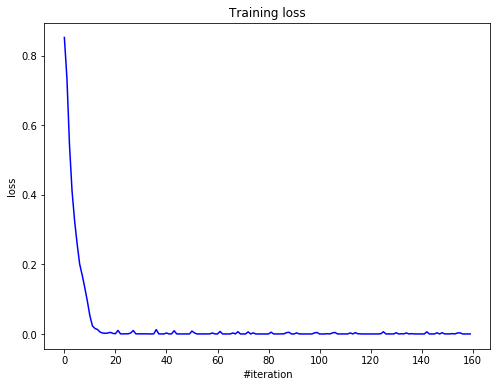

Current loss: 0.000114


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [62]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [63]:
BATCH_SIZE = 1024
N_EPOCH = 10
FEATURE_NUM = X_train.shape[1] * X_train.shape[2]
CLASSES_NUM = len(np.unique(y_train))

One-hot encode the labels first.

In [64]:
# Your code goes here. ################################################
def one_hot(labels):
    if labels.ndim != 1:
        return labels
    
    labels_one_hot = np.zeros((len(labels), len(np.unique(labels))))
    labels_one_hot[np.arange(len(labels)), labels] = 1
    return labels_one_hot

y_train, y_val, y_test = one_hot(y_train), one_hot(y_val), one_hot(y_test)

In [65]:
class DatasetMNIST(Dataset):
    def __init__(self, X, y, transform = None):
        self.X = np.array(X)
        self.y = np.array(y)
        self.transform = transform
        assert (X.shape[0] == y.shape[0])
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        obj = self.X[index]
        label = self.y[index]
        
        if self.transform is not None:
            obj = self.transform(obj)
            
        return obj, label

In [66]:
train_dataset = DatasetMNIST(X_train, y_train, transform=lambda x : x.flatten())
val_dataset = DatasetMNIST(X_val, y_val, transform=lambda x : x.flatten())
test_dataset = DatasetMNIST(X_test, y_test, transform=lambda x : x.flatten())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [67]:
# Your code goes here. ################################################
def SimpleModel(activation_layer, with_batch_norm : bool = False):
    model = Sequential()
    if with_batch_norm:
        model.add(Linear(FEATURE_NUM, CLASSES_NUM))
        model.add(BatchNormalization(0.2))
        model[1].moving_mean = np.zeros(CLASSES_NUM)
        model[1].moving_variance = np.ones(CLASSES_NUM)
        model.add(ChannelwiseScaling(CLASSES_NUM))
        model.add(activation_layer)
        model.add(LogSoftMax())
    else:
        model.add(Linear(FEATURE_NUM, CLASSES_NUM))
        model.add(activation_layer)
        model.add(LogSoftMax())
    
    return model

def train_model(train_loader, val_loader, model, optimizer, optimizer_config,
                criterion = ClassNLLCriterion(), n_epoch = N_EPOCH):
    
    iteration_train_loss = []
    ep_val_loss = []
    optimizer_state = {}
    
    for i in range(n_epoch):
        model.train()
        for X_batch, y_batch in train_loader:
            model.zeroGradParameters()

            # Forward
            predictions = model.forward(X_batch.numpy())
            loss = criterion.forward(predictions, y_batch.numpy())

            # Backward
            dp = criterion.backward(predictions, y_batch.numpy())
            model.backward(X_batch.numpy(), dp)

            # Update weights
            optimizer(
                model.getParameters(), 
                model.getGradParameters(), 
                optimizer_config,
                optimizer_state
            )      

            iteration_train_loss.append(loss)    
            
        val_loss = []
        model.evaluate()
        for X_batch, y_batch in val_loader:
            predictions = model.forward(X_batch.numpy())
            loss = criterion.forward(predictions, y_batch.numpy())
            val_loss.append(loss)
        
        ep_val_loss.append(np.mean(val_loss))
        
        print("epoch: {}\nmean train loss: {}\nmean val loss: {}\n\n".format(
                                            i,
                                            np.mean(iteration_train_loss),
                                            np.mean(ep_val_loss))
             )
        
    return iteration_train_loss, ep_val_loss

### SGD Momentum optimizer

In [76]:
sgd_momentum_config = {
    "learning_rate" : 1e-2,
    "momentum" : 0.9
}

losses_momentum = {}

In [80]:
ReLUModel = SimpleModel(ReLU())
ReLUBNModel = SimpleModel(ReLU(), with_batch_norm=True)

print("[Training ReLU]")
losses_momentum["ReLU"] = train_model(train_loader, val_loader, ReLUModel, sgd_momentum, sgd_momentum_config)
print("[Training ReLUBN]\n")
losses_momentum["ReLUBN"] = train_model(train_loader, val_loader, ReLUBNModel, sgd_momentum, {
    "learning_rate" : 1e-1,
    "momentum" : 0.9
})

[Training ReLU]
epoch: 0
mean train loss: 1.7749559411285833
mean val loss: 1.3275977862154185


epoch: 1
mean train loss: 1.5151815638237303
mean val loss: 1.2437678108586778


epoch: 2
mean train loss: 1.3949751015917675
mean val loss: 1.1924861181961395


epoch: 3
mean train loss: 1.3077054933801873
mean val loss: 1.1250271368394305


epoch: 4
mean train loss: 1.2141694995985248
mean val loss: 1.047945088567368


epoch: 5
mean train loss: 1.1373120977093452
mean val loss: 0.9885385632466098


epoch: 6
mean train loss: 1.0770876309479946
mean val loss: 0.9420713565088489


epoch: 7
mean train loss: 1.0288057407779494
mean val loss: 0.9047065737171038


epoch: 8
mean train loss: 0.9892286743065438
mean val loss: 0.8739541720170237


epoch: 9
mean train loss: 0.9561418789811162
mean val loss: 0.8481553759709977


[Training ReLUBN]

epoch: 0
mean train loss: 1.45029568655488
mean val loss: 0.8284463726051708


epoch: 1
mean train loss: 1.1411627029640699
mean val loss: 0.794717615903363

In [82]:
ELUModel = SimpleModel(ELU())
ELUBNModel = SimpleModel(ELU(), with_batch_norm=True)

print("[Training ELU]\n")
losses_momentum["ELU"] = train_model(train_loader, val_loader, ELUModel, sgd_momentum, sgd_momentum_config)
print("[Training ELUBN]\n")
losses_momentum["ELUBN"] = train_model(train_loader, val_loader, ELUBNModel, sgd_momentum, {
    "learning_rate" : 1e-1,
    "momentum" : 0.9
})

[Training ELU]

epoch: 0
mean train loss: 1.4423008497361516
mean val loss: 0.7852431856262122


epoch: 1
mean train loss: 1.0736850009322931
mean val loss: 0.6762299905734289


epoch: 2
mean train loss: 0.908043935001694
mean val loss: 0.6148908551653413


epoch: 3
mean train loss: 0.810678561639144
mean val loss: 0.5739832979934067


epoch: 4
mean train loss: 0.7451453198205232
mean val loss: 0.5441198129715612


epoch: 5
mean train loss: 0.6974143518385078
mean val loss: 0.5210694721214698


epoch: 6
mean train loss: 0.6606711259876619
mean val loss: 0.5025603537258827


epoch: 7
mean train loss: 0.6313492081374011
mean val loss: 0.48727073239479374


epoch: 8
mean train loss: 0.6072265781269452
mean val loss: 0.4743714540359283


epoch: 9
mean train loss: 0.5869465077886848
mean val loss: 0.46327278145206724


[Training ELUBN]

epoch: 0
mean train loss: 0.9035684230704529
mean val loss: 0.3544773282687982


epoch: 1
mean train loss: 0.6321954972678084
mean val loss: 0.3380063596703

In [84]:
LeakyReLUModel = SimpleModel(LeakyReLU())
LeakyReLUBNModel = SimpleModel(LeakyReLU(), with_batch_norm=True)

print("[Training LeakyReLU]\n")
losses_momentum["LeakyReLU"] = train_model(train_loader, val_loader, LeakyReLUModel, sgd_momentum, sgd_momentum_config)
print("[Training LeakyReLUBN]\n")
losses_momentum["LeakyRELUBN"] = train_model(train_loader, val_loader, LeakyReLUBNModel, sgd_momentum, {
    "learning_rate" : 1e-1,
    "momentum" : 0.9
})

[Training LeakyReLU]

epoch: 0
mean train loss: 1.5564076199457
mean val loss: 0.8393930138524006


epoch: 1
mean train loss: 1.1437900206449672
mean val loss: 0.7086045987352924


epoch: 2
mean train loss: 0.9578231018276674
mean val loss: 0.6379776774086935


epoch: 3
mean train loss: 0.8492681818904303
mean val loss: 0.5918800212854564


epoch: 4
mean train loss: 0.7766750177613122
mean val loss: 0.5587520528077373


epoch: 5
mean train loss: 0.7240632335958539
mean val loss: 0.5333695085043926


epoch: 6
mean train loss: 0.6837903892015557
mean val loss: 0.5131810074669935


epoch: 7
mean train loss: 0.6517604730733875
mean val loss: 0.4966038695793887


epoch: 8
mean train loss: 0.6255168525387607
mean val loss: 0.48269074661280026


epoch: 9
mean train loss: 0.6035363667476491
mean val loss: 0.47077412600522617


[Training LeakyReLUBN]

epoch: 0
mean train loss: 1.0308921964492386
mean val loss: 0.3653839642535889


epoch: 1
mean train loss: 0.6974162328400041
mean val loss: 0.33

In [86]:
SoftPlusModel = SimpleModel(SoftPlus())
SoftPlusBNModel = SimpleModel(SoftPlus(), with_batch_norm=True)

print("[Training SoftPlus]\n")
losses_momentum["LeakyReLU"] = train_model(train_loader, val_loader, SoftPlusModel, sgd_momentum, sgd_momentum_config)
print("[Training SoftPlusBN]\n")
losses_momentum["LeakyRELUBN"] = train_model(train_loader, val_loader, SoftPlusBNModel, sgd_momentum, {
    "learning_rate" : 1e-1,
    "momentum" : 0.9
})

[Training SoftPlus]

epoch: 0
mean train loss: 1.7443248738777222
mean val loss: 0.9878231503044257


epoch: 1
mean train loss: 1.269767295391179
mean val loss: 0.7966897163714799


epoch: 2
mean train loss: 1.0481646619902996
mean val loss: 0.7007514057282934


epoch: 3
mean train loss: 0.9196481788182435
mean val loss: 0.6406788221206433


epoch: 4
mean train loss: 0.8344422518410755
mean val loss: 0.5986704808375107


epoch: 5
mean train loss: 0.7730779722571802
mean val loss: 0.5672472685732413


epoch: 6
mean train loss: 0.7263904264739579
mean val loss: 0.5425687806199347


epoch: 7
mean train loss: 0.6894466388058527
mean val loss: 0.522563196987817


epoch: 8
mean train loss: 0.6593647548431664
mean val loss: 0.5059517108101563


epoch: 9
mean train loss: 0.6342703052327376
mean val loss: 0.4918609013305776


[Training SoftPlusBN]

epoch: 0
mean train loss: 1.1284458785259623
mean val loss: 0.3735257560186852


epoch: 1
mean train loss: 0.746624808180964
mean val loss: 0.341859

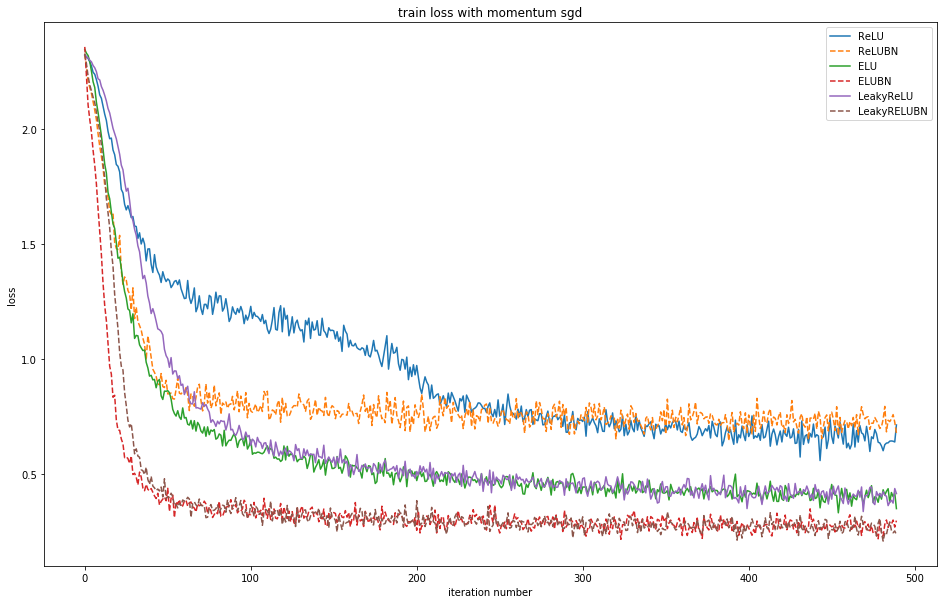

In [87]:
plt.figure(figsize=(16, 10))

for key in losses_momentum:
    if key.find("BN") != -1:
        plt.plot(losses_momentum[key][0], label=key, linestyle = '--')
    else:
        plt.plot(losses_momentum[key][0], label=key)

plt.title("train loss with momentum sgd")
plt.xlabel("iteration number")
plt.ylabel("loss")
plt.legend()
plt.show()

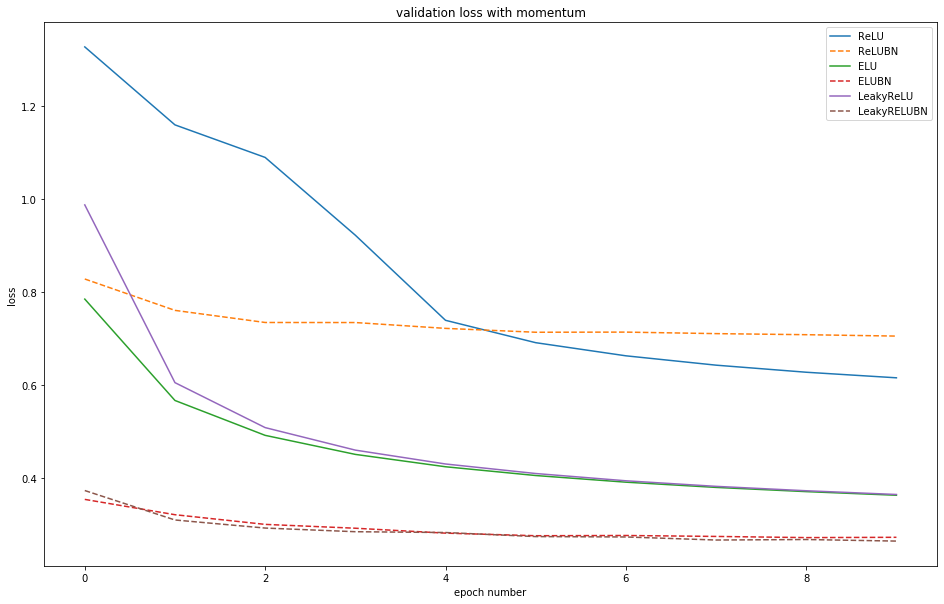

In [88]:
plt.figure(figsize=(16, 10))

for key in losses_momentum:
    if key.find("BN") != -1:
        plt.plot(losses_momentum[key][1], label=key, linestyle = '--')
    else:
        plt.plot(losses_momentum[key][1], label=key)

plt.title("validation loss with momentum")
plt.xlabel("epoch number")
plt.ylabel("loss")
plt.legend()
plt.show()

### Adam optimizer

In [114]:
adam_config_default = {
    "learning_rate" : 1e-3,
    "beta1" : 0.9,
    "beta2" : 0.999,
    "epsilon" : 1e-8
}

losses_adam = {}

In [115]:
ReLUModel = SimpleModel(ReLU())
ReLUBNModel = SimpleModel(ReLU(), with_batch_norm=True)

print("[Training ReLU]\n")
losses_adam["ReLU"] = train_model(train_loader, val_loader, ReLUModel, adam_optimizer, adam_config_default)
print("[Training ReLUBN]\n")
losses_adam["ReLUBN"] = train_model(train_loader, val_loader, ReLUBNModel, adam_optimizer, {
    "learning_rate" : 5e-2,
    "beta1" : 0.9,
    "beta2" : 0.999,
    "epsilon" : 1e-8
})

[Training ReLU]

epoch: 0
mean train loss: 1.6840427873295682
mean val loss: 1.176600328913263


epoch: 1
mean train loss: 1.362463149399707
mean val loss: 1.0248908027896326


epoch: 2
mean train loss: 1.1920909104180122
mean val loss: 0.9345106367218428


epoch: 3
mean train loss: 1.0842713723193391
mean val loss: 0.8732168972446156


epoch: 4
mean train loss: 1.0087620015833498
mean val loss: 0.8282982027899652


epoch: 5
mean train loss: 0.9523240382943919
mean val loss: 0.7936851622621122


epoch: 6
mean train loss: 0.9081997153983706
mean val loss: 0.7659671169185905


epoch: 7
mean train loss: 0.8725851152671401
mean val loss: 0.7431413499065826


epoch: 8
mean train loss: 0.8430504303948922
mean val loss: 0.7239398754354711


epoch: 9
mean train loss: 0.8180739266004151
mean val loss: 0.707557767706395


[Training ReLUBN]

epoch: 0
mean train loss: 1.1445413532062965
mean val loss: 0.6708623129254327


epoch: 1
mean train loss: 0.8895991216312576
mean val loss: 0.62614204352212

In [116]:
ELUModel = SimpleModel(ELU())
ELUBNModel = SimpleModel(ELU(), with_batch_norm=True)

print("[Training ELU]\n")
losses_adam["ELU"] = train_model(train_loader, val_loader, ELUModel, adam_optimizer, adam_config_default)
print("[Training ELUBN]\n")
losses_adam["ELUBN"] = train_model(train_loader, val_loader, ELUBNModel, adam_optimizer, {
    "learning_rate" : 5e-2,
    "beta1" : 0.9,
    "beta2" : 0.999,
    "epsilon" : 1e-8
})

[Training ELU]

epoch: 0
mean train loss: 1.540622712523373
mean val loss: 0.9752168839028057


epoch: 1
mean train loss: 1.185980407270255
mean val loss: 0.8102278223428454


epoch: 2
mean train loss: 0.9993433493614791
mean val loss: 0.7136002515228954


epoch: 3
mean train loss: 0.8823659928708977
mean val loss: 0.6490692061482075


epoch: 4
mean train loss: 0.8010775302450431
mean val loss: 0.6021501950231127


epoch: 5
mean train loss: 0.7406944474824442
mean val loss: 0.5661848967210448


epoch: 6
mean train loss: 0.6937308723976594
mean val loss: 0.5375828563907713


epoch: 7
mean train loss: 0.6560025247937498
mean val loss: 0.5143062040986943


epoch: 8
mean train loss: 0.6248895733691442
mean val loss: 0.49481712813922624


epoch: 9
mean train loss: 0.5987181375402103
mean val loss: 0.47826583022571195


[Training ELUBN]

epoch: 0
mean train loss: 0.9862246582136115
mean val loss: 0.4263004933013024


epoch: 1
mean train loss: 0.6924527898486944
mean val loss: 0.3774369069985

In [117]:
LeakyReLUModel = SimpleModel(LeakyReLU())
LeakyReLUBNModel = SimpleModel(LeakyReLU(), with_batch_norm=True)

print("[Training LeakyReLU]\n")
losses_adam["LeakyReLU"] = train_model(train_loader, val_loader, LeakyReLUModel, adam_optimizer, adam_config_default)
print("[Training LeakyReLUBN]\n")
losses_adam["LeakyRELUBN"] = train_model(train_loader, val_loader, LeakyReLUBNModel, adam_optimizer, {
    "learning_rate" : 5e-2,
    "beta1" : 0.9,
    "beta2" : 0.999,
    "epsilon" : 1e-8
})

[Training LeakyReLU]

epoch: 0
mean train loss: 1.6463420781191953
mean val loss: 1.0476948204575078


epoch: 1
mean train loss: 1.2515989364472748
mean val loss: 0.8495090184721621


epoch: 2
mean train loss: 1.0426848024794428
mean val loss: 0.7387490715402505


epoch: 3
mean train loss: 0.9136093896148598
mean val loss: 0.6665422054176307


epoch: 4
mean train loss: 0.8249433559073028
mean val loss: 0.6149972823277416


epoch: 5
mean train loss: 0.7596591845312981
mean val loss: 0.575976528395424


epoch: 6
mean train loss: 0.709250195581903
mean val loss: 0.5452495684488279


epoch: 7
mean train loss: 0.6689671902012457
mean val loss: 0.5203455150950977


epoch: 8
mean train loss: 0.6358832906069065
mean val loss: 0.49968312243599183


epoch: 9
mean train loss: 0.6081643376439666
mean val loss: 0.4822034503748844


[Training LeakyReLUBN]

epoch: 0
mean train loss: 0.934458614856133
mean val loss: 0.40981563933969734


epoch: 1
mean train loss: 0.6612137593483978
mean val loss: 0.36

In [118]:
SoftPlusModel = SimpleModel(SoftPlus())
SoftPlusBNModel = SimpleModel(SoftPlus(), with_batch_norm=True)

print("[Training SoftPlus]\n")
losses_adam["LeakyReLU"] = train_model(train_loader, val_loader, SoftPlusModel, adam_optimizer, adam_config_default)
print("[Training SoftPlusBN]\n")
losses_adam["LeakyRELUBN"] = train_model(train_loader, val_loader, SoftPlusBNModel, adam_optimizer, {
    "learning_rate" : 5e-2,
    "beta1" : 0.9,
    "beta2" : 0.999,
    "epsilon" : 1e-8
})

[Training SoftPlus]

epoch: 0
mean train loss: 1.646907250827612
mean val loss: 1.0124902018767972


epoch: 1
mean train loss: 1.2372886141764983
mean val loss: 0.8159706383164178


epoch: 2
mean train loss: 1.0252657561819263
mean val loss: 0.7087096937929237


epoch: 3
mean train loss: 0.8958274059829628
mean val loss: 0.6394624862819175


epoch: 4
mean train loss: 0.8075714403885831
mean val loss: 0.5903964877142056


epoch: 5
mean train loss: 0.7429760154005841
mean val loss: 0.5534094534977295


epoch: 6
mean train loss: 0.693289662230956
mean val loss: 0.5243573430024031


epoch: 7
mean train loss: 0.6536861400773841
mean val loss: 0.5008708384510234


epoch: 8
mean train loss: 0.6212833362906216
mean val loss: 0.4814844809217008


epoch: 9
mean train loss: 0.5941758855883236
mean val loss: 0.4650191595378629


[Training SoftPlusBN]

epoch: 0
mean train loss: 1.0592844346494268
mean val loss: 0.4027868529983441


epoch: 1
mean train loss: 0.7213010119658727
mean val loss: 0.36162

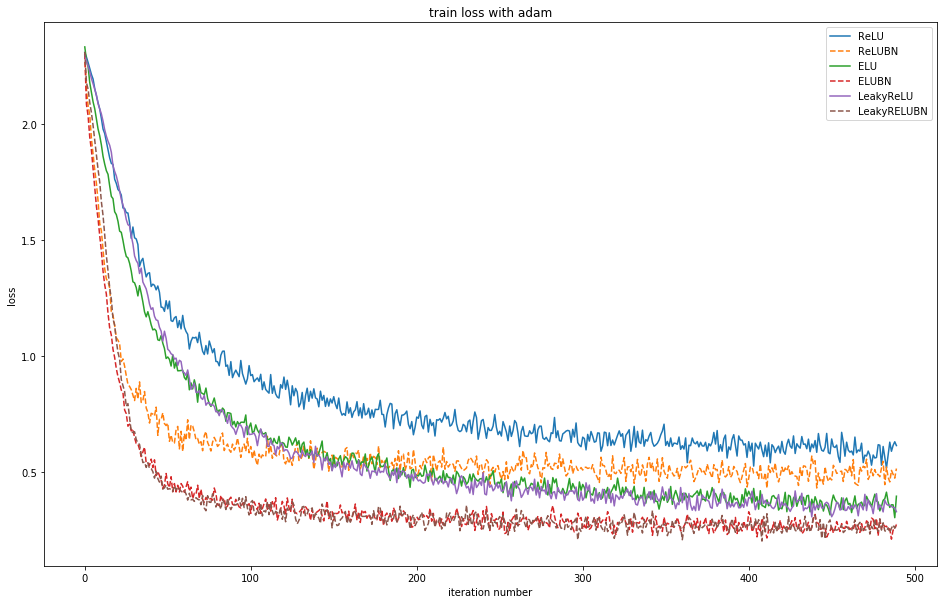

In [119]:
plt.figure(figsize=(16, 10))

for key in losses_adam:
    if key.find("BN") != -1:
        plt.plot(losses_adam[key][0], label=key, linestyle = '--')
    else:
        plt.plot(losses_adam[key][0], label=key)

plt.title("train loss with adam")
plt.xlabel("iteration number")
plt.ylabel("loss")
plt.legend()
plt.show()

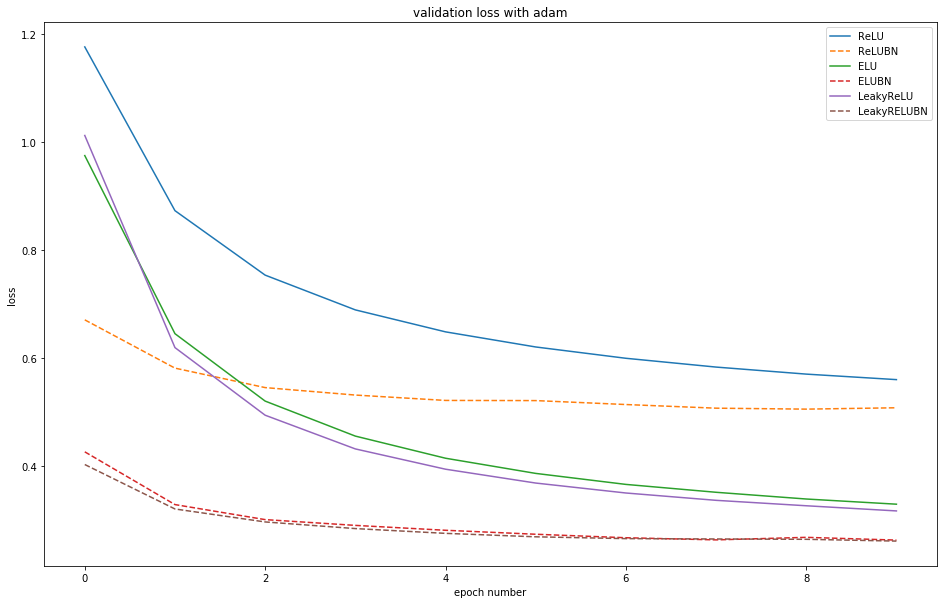

In [120]:
plt.figure(figsize=(16, 10))

for key in losses_adam:
    if key.find("BN") != -1:
        plt.plot(losses_adam[key][1], label=key, linestyle = '--')
    else:
        plt.plot(losses_adam[key][1], label=key)

plt.title("validation loss with adam")
plt.xlabel("epoch number")
plt.ylabel("loss")
plt.legend()
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

- Лучше всего в обоих случая показала себя ELU, хуже остальных - ReLU. Однако ELU содержит exp, которую затратно вычислять, поэтому я склоняюсь к выбору LeakyReLU, которая лишена проблемы ReLU с нулевым градиентом, а также вычислительно не затратна

- Добавление батчнорма позволяет обучаться лучше увеличивая learning_rate, тк нормируя выход с линейного слоя мы получаем гарантию того, что данные в следующий слой скорее всего придут с mean = 0, variance = 1 и мы можем изменять веса на бо'льшую величину, по сравнению с моделью без батчнорма. Также наличие shift + scale позволяет тюнить эти параметры, адаптируясь под следующий слой.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [ ]:
# Your code goes here. ################################################

Print here your accuracy on test set. It should be around 90%.

In [ ]:
# Your answer goes here. ################################################

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [ ]:
# Your beautiful code here.